In [1]:
# !pip install konlpy
# !pip install mecab-python
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [2]:
import re
import pandas as pd
from typing import List, Tuple

# =========================
# 0) CSV에서 형용사 로드 + 패턴화
# =========================
CSV_PATH = "/content/drive/MyDrive/seoul_datahub_contest/top_100_adjectives.csv"
ADJ_COL  = "형용사"                    # CSV의 컬럼명

# === 입력 & 출력 경로 ===
IN_PATH = "/content/drive/MyDrive/seoul_datahub_contest/selected_sentences.csv"
OUT_PATH = "/content/drive/MyDrive/seoul_datahub_contest/sentiment_summary_by_entity.csv"
TEXT_COL = "content_clean"
SEARCH_COL = "search_query"

ENTITIES = [
    "도산근린공원", "율현공원", "경의선숲길", "문화비축기지", "올림픽공원",
    "송파나루근린공원(석촌호수)", "인왕산도시자연공원(인왕산)", "낙산공원",
    "북한산국립공원(북한산)", "서울로 7017", "남산공원", "용산가족공원",
    "효창근린공원(효창공원)", "강서한강공원", "난지한강공원", "양화한강공원",
    "망원한강공원", "여의도한강공원", "이촌한강공원", "반포한강공원", "잠원한강공원",
    "뚝섬한강공원", "잠실한강공원", "광나루한강공원"
]

def load_adjectives(csv_path: str, col: str) -> List[str]:
    df = pd.read_csv(csv_path)
    if col not in df.columns:
        raise ValueError(f"'{col}' 컬럼을 찾을 수 없습니다. 실제 컬럼들: {list(df.columns)}")
    # 문자열로 변환 + 결측 제거
    words = df[col].dropna().astype(str).tolist()
    return list(dict.fromkeys(w.strip() for w in words if w.strip()))  # 중복 제거

def to_stem_pattern(word: str) -> str:
    """
    형용사 원형(~다)이 들어오면 '다' 제거한 어간을 정규식으로 반환.
    예) 예쁘다 -> 예쁘, 깨끗하다 -> 깨끗하 (활용형 전반 매칭을 위해 접미어 제한 안 둠)
    """
    w = word.strip()
    if w.endswith("다") and len(w) >= 2:
        stem = w[:-1]  # '다' 제거
    else:
        stem = w
    # 정규식 특수문자 이스케이프
    return re.escape(stem)

def build_patterns_from_words(words: List[str]) -> List[str]:
    """
    CSV에서 읽은 형용사들을 정규식 패턴(어간 매칭) 리스트로 변환.
    """
    patterns = [to_stem_pattern(w) for w in words]
    # 빈 문자열/중복 제거
    patterns = [p for p in dict.fromkeys(patterns) if p]
    return patterns

# CSV에서 상위 형용사 100개 읽기
csv_adjs = load_adjectives(CSV_PATH, ADJ_COL)

# 1) 긍정, 부정 형용사 20개씩 리스트업
USER_POS_WORDS = [
    "깨끗하다", "조용하다", "알차다", "아름답다", "멋지다", "편하다", "시원하다", "좋아하다", "설레다",
    "행복하다", "즐겁다", "귀엽다", "완벽하다", "대단하다", "잔잔하다", "소중하다", "딱이다", "한가롭다", "근사하다"
]
USER_NEG_WORDS = [
    "아쉽다", "힘들다", "필요하다", "어렵다",  "무섭다", "아프다", "비싸다", "밉다",
    "바쁘다", "아깝다", "불편하다", "덥다", "나쁘다", "좁다", "이상하다", "헷갈리다", "귀찮다", "드럽다"
]

# CSV에서 가져온 전체 형용사 중에서 내가 고른 것만(=USER_*) 패턴으로 변환
POS_PATTERNS = build_patterns_from_words(USER_POS_WORDS)
NEG_PATTERNS = build_patterns_from_words(USER_NEG_WORDS)

# =========================
# 2) 부정 표지(negation shifters) & 보조 함수
# =========================
NEGATION_TOKENS = [r"안", r"못", r"별로", r"전혀", r"않", r"아니"]

def normalize(text: str) -> str:
    t = text.strip().lower()
    t = re.sub(r"(ㅋ|ㅎ){2,}", " ", t)
    t = re.sub(r"!{2,}", "!", t)
    t = re.sub(r"\?{2,}", "?", t)
    t = re.sub(r"[^\w\s가-힣!?.,]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def any_match(patterns: List[str], text: str) -> List[Tuple[str, Tuple[int,int]]]:
    hits = []
    for p in patterns:
        # 어간 매칭: 조사/어미/활용형 전반을 잡기 위해 단어경계(\b) 대신 부분일치 사용
        for m in re.finditer(p, text):
            hits.append((p, m.span()))
    return hits

def has_negation_nearby(text: str, span: Tuple[int,int], window:int=4) -> bool:
    start, end = span
    left  = max(0, start - window)
    right = min(len(text), end + window)
    ctx = text[left:right]
    return any(re.search(nt, ctx) for nt in NEGATION_TOKENS)

def classify_sentiment_with_prob(text: str) -> Tuple[str, float]:
    t = normalize(text)
    if any_match(NEG_PATTERNS, t):
        return "부정", 0.0
    pos_hits = any_match(POS_PATTERNS, t)
    if pos_hits:
        for _, span in pos_hits:
            if has_negation_nearby(t, span, window=4):
                return "부정", 0.0
        return "긍정", 1.0
    return "중립", 0.5

In [3]:
df = pd.read_csv(IN_PATH)
df["entity"] = ENTITIES * (len(df) // len(ENTITIES)) + ENTITIES[:len(df) % len(ENTITIES)]

# 감성 분석 적용
df[["sentiment_rule", "positive_prob"]] = df[TEXT_COL].fillna("").apply(
    lambda x: pd.Series(classify_sentiment_with_prob(x))
)

# 집계
summary = df.groupby("entity").agg(
    n_docs=(TEXT_COL, "count"),
    n_positive=("sentiment_rule", lambda x: (x == "긍정").sum()),
    n_negative=("sentiment_rule", lambda x: (x == "부정").sum()),
    positive_rate=("sentiment_rule", lambda x: (x == "긍정").mean()),
    mean_positive_prob=("positive_prob", "mean")
).reset_index()

# 저장
summary.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print(f"저장 완료: {OUT_PATH}")

저장 완료: /content/drive/MyDrive/seoul_datahub_contest/sentiment_summary_by_entity.csv


## 한글 적용

In [4]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [5]:
import matplotlib.pyplot as plt

# 나눔고딕 폰트 경로 설정
plt.rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정 완료.")

한글 폰트 설정 완료.


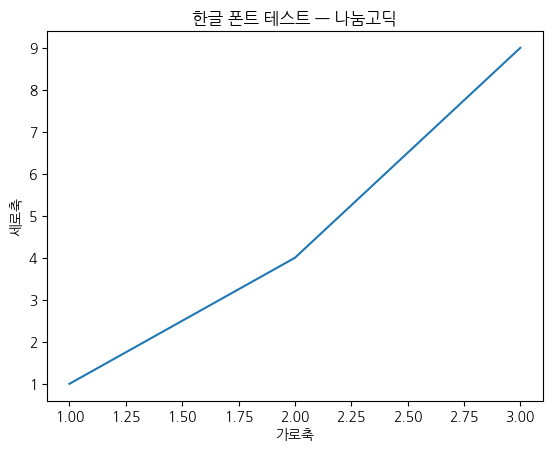

In [6]:
# 확실한 한글 폰트 설정 (Colab)
import matplotlib, matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import os

# 1) 나눔고딕 파일이 있는지 확인 (apt로 이미 설치된 경로)
nanum_paths = [
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
    "/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf"
]
for p in nanum_paths:
    if os.path.exists(p):
        font_manager.fontManager.addfont(p)   # 2) Matplotlib에 직접 등록

# 3) 폰트 패밀리 지정
rcParams["font.family"] = "NanumGothic"
rcParams["axes.unicode_minus"] = False

# 4) (선택) 캐시 재빌드
try:
    matplotlib.font_manager._rebuild()
except Exception:
    pass

# 5) 간단 테스트
plt.figure()
plt.title("한글 폰트 테스트 — 나눔고딕")
plt.xlabel("가로축"); plt.ylabel("세로축")
plt.plot([1,2,3],[1,4,9])
plt.show()


## 중립 표현

In [7]:
import os, matplotlib.pyplot as plt
import numpy as np

SUMMARY_PATH = "/content/drive/MyDrive/seoul_datahub_contest/sentiment_summary_by_entity.csv"
RAW_PATH = "/content/drive/MyDrive/seoul_datahub_contest/selected_sentences.csv"
TEXT_COL = "content_clean"

# 요약 CSV 없으면 생성
if not os.path.exists(SUMMARY_PATH):
    raw=pd.read_csv(RAW_PATH)
    raw["entity"]=raw[TEXT_COL].apply(lambda x: ENTITIES[0] if len(ENTITIES)>0 else "") # Modified: Assign a default entity if extraction fails
    labs_probs=raw[TEXT_COL].fillna("").apply(classify_sentiment_with_prob)
    raw["sentiment_rule"]=[s for s,_ in labs_probs]
    raw["positive_prob"]=[p for _,p in labs_probs]
    summary=raw.groupby("entity").agg(
        n_docs=(TEXT_COL,"count"),
        n_positive=("sentiment_rule",lambda x:(x=="긍정").sum()),
        n_negative=("sentiment_rule",lambda x:(x=="부정").sum()),
        positive_rate=("sentiment_rule",lambda x:(x=="긍정").mean() if len(x)>0 else 0.0),
        mean_positive_prob=("positive_prob","mean")
    ).reset_index()
    summary.to_csv(SUMMARY_PATH,index=False,encoding="utf-8-sig")
else:
    summary=pd.read_csv(SUMMARY_PATH)

# n_neutral = 전체 - 긍정 - 부정
if "n_neutral" not in summary.columns:
    summary["n_neutral"] = summary["n_docs"] - summary["n_positive"] - summary["n_negative"]
    summary["n_neutral"] = summary["n_neutral"].clip(lower=0)

summary=summary.sort_values("n_docs",ascending=False).reset_index(drop=True)
min_docs=5

In [8]:
# !pip install konlpy

In [9]:
# ===== 2번 그래프 직전: 공원별 Top-1 긍/부정 키워드 + '명사만' 문맥 라벨 =====
from collections import Counter, defaultdict
import math, re, pandas as pd
from typing import List, Tuple

# 0) 패턴<->표시용 원형 매핑 (이미 있는 리스트 사용)
POS_PAIR = list(zip(POS_PATTERNS, USER_POS_WORDS))
NEG_PAIR = list(zip(NEG_PATTERNS, USER_NEG_WORDS))
DISP2PATT = {disp: patt for patt, disp in POS_PAIR + NEG_PAIR}

# 1) 원본 로드 + 엔티티 매핑(현재 코드의 순환 배정과 동일)
df_kw = pd.read_csv(IN_PATH)
df_kw["entity"] = ENTITIES * (len(df_kw) // len(ENTITIES)) + ENTITIES[:len(df_kw) % len(ENTITIES)]

# 2) 명사 추출기: konlpy 있으면 '품사=명사'만, 없으면 휴리스틱
# 제외할 단어 - 형용사를 꾸밀 수 없는 부사, 이상한 단어, 흔한 명사 등
STOPWORDS = {"조금","좀","약간","매우","너무","정말","진짜","되게","굉장히","상당히","다시", "떡볶이",
             "아쉽긴","그냥","그리고","또","또한","그래도","멀리","우리","허밍","웨이","사패산","이번","석굴암","중간",
             "이곳","여기","거기","저기","부분","정도","사실","때문","사진","영상","북한",
             "공원","한강"}

try:
    # from konlpy.tag import Okt
    from konlpy.tag import Mecab # Mecab으로 변경
    _mecab = Mecab()             # Mecab으로 변경
    # _okt = Okt()
    def nouns_only(s: str):
        # 품사로 필터 → 명사만
        # return [w for (w,t) in _okt.pos(str(s), norm=True, stem=True)
        #         if t == "Noun" and len(w) >= 2 and w not in STOPWORDS]
        return [w for w in _mecab.nouns(str(s)) # Mecab 명사 추출
                if len(w) >= 2 and w not in STOPWORDS]

except Exception:
    def nouns_only(s: str):
        # 간단 휴리스틱: 한글 2자 이상 + 용언/부사 어미 제거
        t = normalize(str(s))
        toks = re.findall(r"[가-힣]{2,}", t)
        drop_suffix = ("하다","스럽","답","같","되","싶","않","있","없","다")
        return [w for w in toks if not any(w.endswith(sf) for sf in drop_suffix) and w not in STOPWORDS]

# 3) 사용자 리스트 한정 카운트(+긍정 뒤집기)
pos_cnt = defaultdict(Counter); neg_cnt = defaultdict(Counter)
for _, r in df_kw.iterrows():
    ent = r["entity"]; t = normalize(str(r[TEXT_COL]))
    for patt, disp in POS_PAIR:
        for m in re.finditer(patt, t):
            if has_negation_nearby(t, m.span(), window=4): neg_cnt[ent][disp] += 1
            else:                                           pos_cnt[ent][disp] += 1
    for patt, disp in NEG_PAIR:
        for _ in re.finditer(patt, t):                      neg_cnt[ent][disp] += 1

# (선택) 너무 흔한 키워드 완화: IDF
def _idf(counts_by_ent):
    keys = set(k for ent in counts_by_ent for k in counts_by_ent[ent])
    N = len(counts_by_ent)
    dfmap = {k: sum(1 for ent in counts_by_ent if counts_by_ent[ent][k] > 0) for k in keys}
    return {k: math.log((N+1)/(df+1)) + 1.0 for k, df in dfmap.items()}
idf_pos, idf_neg = _idf(pos_cnt), _idf(neg_cnt)

def _top1(cnts: Counter, idfmap: dict):
    if not cnts: return ("—", 0)
    best = max(((k, v, v*idfmap.get(k,1.0)) for k, v in cnts.items()), key=lambda x: (x[2], x[1]))
    return (best[0], int(best[1]))

# 4) 2번 그래프 대상(top15) 엔티티의 Top-1 키워드
# top15_ents = summary.sort_values("n_docs", ascending=False).head(15)["entity"].tolist()
ents_for_plot = ENTITIES[:]  # ENTITIES 순서대로 표시 (원하면 정렬 조건 바꿔도 됨)

kw_rows = []
for ent in ents_for_plot:
    kw_rows.append({
        "entity": ent,
        "top_pos_kw": _top1(pos_cnt.get(ent, Counter()), idf_pos)[0],
        "top_neg_kw": _top1(neg_cnt.get(ent, Counter()), idf_neg)[0],
    })
kw_df = pd.DataFrame(kw_rows)

# summary에 없는 엔티티도 0으로 채워서 포함
summary_all = pd.DataFrame({"entity": ents_for_plot}).merge(summary, on="entity", how="left")
for c in ["n_docs","n_positive","n_neutral","n_negative","positive_rate","mean_positive_prob"]:
    if c in summary_all.columns:
        summary_all[c] = summary_all[c].fillna(0)

# 5) '명사만' 문맥에서 대표 명사 1개 추출
texts_by_ent = {e: df_kw.loc[df_kw["entity"]==e, TEXT_COL].tolist() for e in ents_for_plot}

def top_noun_around(disp_kw: str, texts, window_char=40):
    if not disp_kw or disp_kw == "—": return "—"
    patt = DISP2PATT.get(disp_kw);  total = Counter()
    for tx in texts:
        t = normalize(str(tx))
        for m in re.finditer(patt, t):
            L = max(0, m.start()-window_char); R = min(len(t), m.end()+window_char)
            total.update(nouns_only(t[L:R]))   # ★ 명사만
    # 키워드 자체/어간 & 불용어 제거
    stem = disp_kw[:-1] if disp_kw.endswith("다") else disp_kw
    for stop in {stem, disp_kw} | STOPWORDS: total.pop(stop, None)
    return total.most_common(1)[0][0] if total else "—"

kw_df["pos_noun"] = kw_df.apply(lambda r: top_noun_around(r["top_pos_kw"], texts_by_ent[r["entity"]]), axis=1)
kw_df["neg_noun"] = kw_df.apply(lambda r: top_noun_around(r["top_neg_kw"], texts_by_ent[r["entity"]]), axis=1)

# 6) 2번 그래프용 DF
summary_docs_kw = summary_all.merge(kw_df, on="entity", how="left")
summary_docs_kw["pos_label"] = summary_docs_kw.apply(
    lambda r: f"{r['top_pos_kw']} | {r['pos_noun']}" if r["top_pos_kw"] not in [None,"—"] else "—", axis=1)
summary_docs_kw["neg_label"] = summary_docs_kw.apply(
    lambda r: f"{r['top_neg_kw']} | {r['neg_noun']}" if r["top_neg_kw"] not in [None,"—"] else "—", axis=1)

# 그래프 그리기

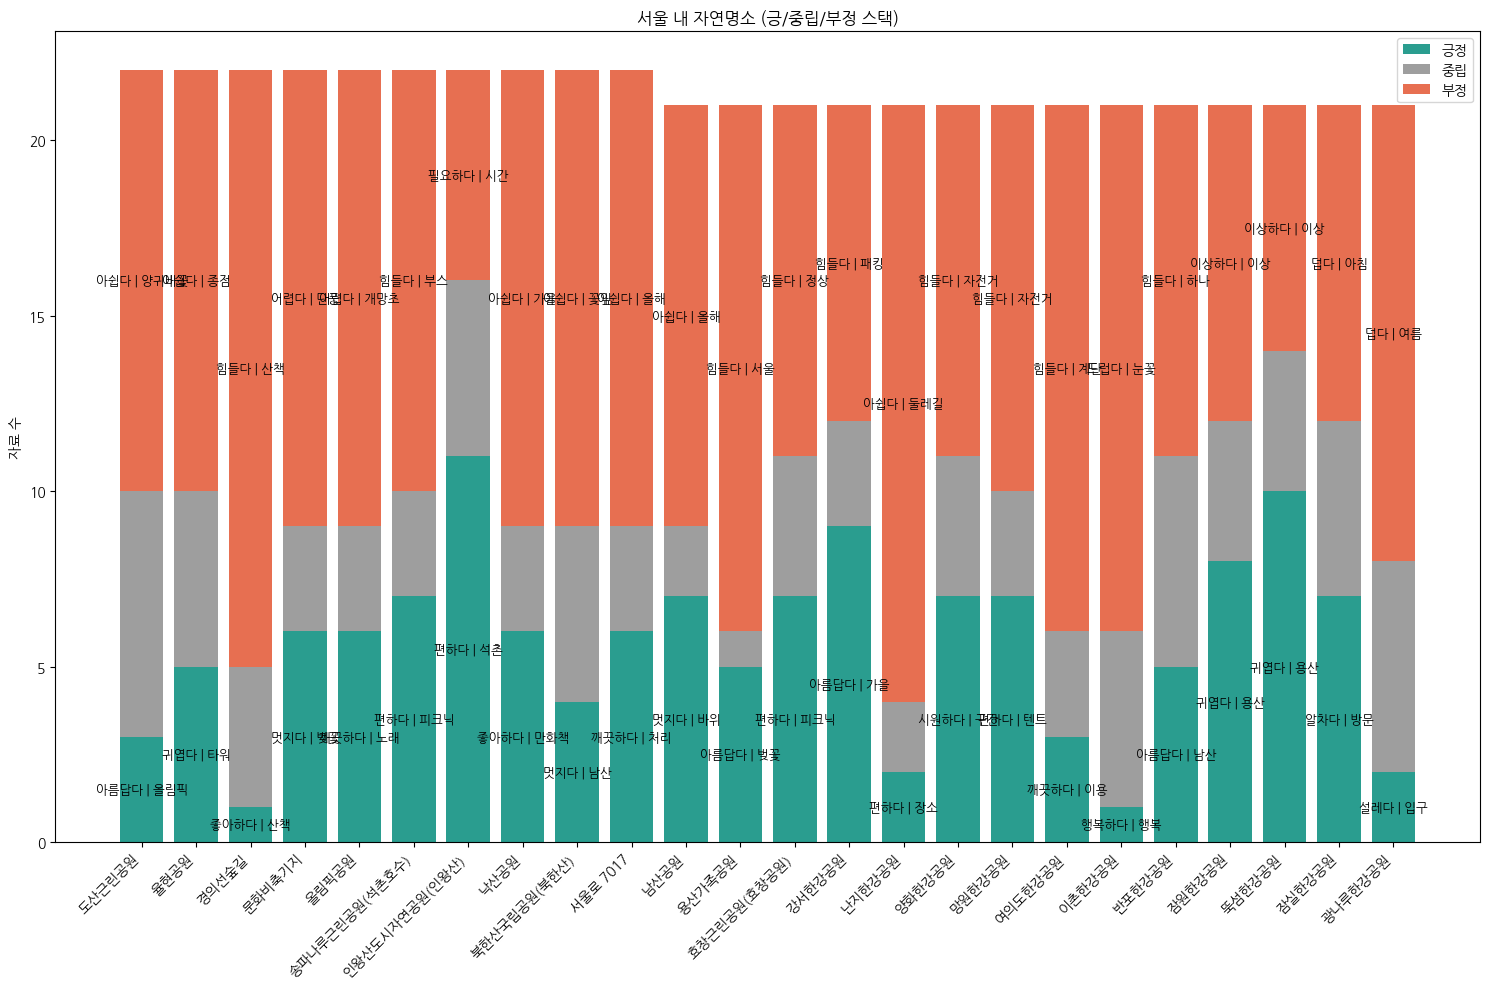

문맥 요약 저장: /content/drive/MyDrive/top_keywords_reasons_by_entity.csv


In [10]:
# 6) 그래프 2를 summary_docs_kw로 다시 그림 (라벨 교체)
x = np.arange(len(summary_docs_kw))
pos = summary_docs_kw["n_positive"].to_numpy()
neu = summary_docs_kw["n_neutral"].to_numpy()
neg = summary_docs_kw["n_negative"].to_numpy()

# 색 팔레트 한번만 정의(원하는 색으로 바꿔도 됨)
POS_COLOR = "#2a9d8f"  # 긍정(초록빛)
NEU_COLOR = "#9e9e9e"  # 중립(회색)
NEG_COLOR = "#e76f51"  # 부정(주황/붉은빛)

plt.figure(figsize=(15,10))
plt.bar(x, pos, color=POS_COLOR, label="긍정")
plt.bar(x, neu, bottom=pos, color=NEU_COLOR, label="중립")
plt.bar(x, neg, bottom=pos+neu, color=NEG_COLOR, label="부정")
plt.xticks(x, summary_docs_kw["entity"], rotation=45, ha="right")
plt.ylabel("자료 수")
plt.title("서울 내 자연명소 (긍/중립/부정 스택)")
plt.tight_layout()
plt.legend()

for i, r in summary_docs_kw.iterrows():
    if r["n_positive"] > 0:
        plt.text(i, r["n_positive"]*0.5, r["pos_label"], ha="center", va="center", fontsize=9)
    if r["n_negative"] > 0:
        plt.text(i, r["n_positive"]+r["n_neutral"]+r["n_negative"]*0.5,
                 r["neg_label"], ha="center", va="center", fontsize=9)

plt.show()

# 7) 문맥 요약 CSV 저장 (분석 확인용)
ctx_out = "/content/drive/MyDrive/top_keywords_reasons_by_entity.csv"
cols = [
    "entity","n_docs",
    "top_pos_kw","pos_noun",
    "top_neg_kw","neg_noun",
    "pos_label","neg_label"
]
summary_docs_kw[cols].to_csv(ctx_out, index=False, encoding="utf-8-sig")

print("문맥 요약 저장:", ctx_out)

# 예쁘다만 보이게!

In [11]:
# # 6) 그래프 2를 summary_docs_kw로 다시 그림 (라벨 교체)
# x = np.arange(len(summary_docs_kw))
# pos = summary_docs_kw["n_positive"].to_numpy()
# neu = summary_docs_kw["n_neutral"].to_numpy()
# neg = summary_docs_kw["n_negative"].to_numpy()

# # === 색상 팔레트 정의 ===
# # 기본 색상
# POS_COLOR = "#9e9e9e"       # 긍정(초록빛)
# NEU_COLOR = "#9e9e9e"       # 중립(회색)
# NEG_COLOR = "#9e9e9e"       # 부정(주황/붉은빛)
# # '예쁘다'/'이쁘다' 강조 색상
# HIGHLIGHT_COLOR = "#ff69b4" # 긍정 (핫핑크)


# # === 그래프 그리기 시작 ===
# plt.figure(figsize=(15,10))

# # 1. 막대를 하나씩 순회하며 조건에 따라 다른 색으로 그리기
# for i, r in summary_docs_kw.iterrows():
#     # 긍정 라벨에 '예쁘다' 또는 '이쁘다'가 포함되어 있는지 확인
#     is_pretty = "예쁘다" in r["pos_label"] or "이쁘다" in r["pos_label"]

#     # 조건에 따라 긍정 막대의 색상 결정
#     current_pos_color = HIGHLIGHT_COLOR if is_pretty else POS_COLOR

#     # 해당 막대의 긍정, 중립, 부정 부분을 각각 그리기
#     plt.bar(i, pos[i], color=current_pos_color)
#     plt.bar(i, neu[i], bottom=pos[i], color=NEU_COLOR)
#     plt.bar(i, neg[i], bottom=pos[i] + neu[i], color=NEG_COLOR)

# # 2. 범례(Legend)를 위한 가상 핸들 생성
# # 실제 데이터 없이 색상과 라벨만 있는 '가짜' 막대를 만들어 범례를 깔끔하게 표시
# import matplotlib.patches as mpatches

# legend_handles = [
#     mpatches.Patch(color=HIGHLIGHT_COLOR, label="긍정 ('예쁘다'/'이쁘다')"),
#     mpatches.Patch(color=POS_COLOR, label="긍정 (기타)"),
#     mpatches.Patch(color=NEU_COLOR, label="중립"),
#     mpatches.Patch(color=NEG_COLOR, label="부정")
# ]
# plt.legend(handles=legend_handles)


# # 3. X축, Y축, 제목 등 기타 설정 (기존과 동일)
# plt.xticks(x, summary_docs_kw["entity"], rotation=45, ha="right")
# plt.ylabel("자료 수")
# plt.title("서울 내 자연명소 (긍/중립/부정 스택) - '예쁘다' 키워드 강조", pad=15)
# plt.tight_layout()

# # 4. 막대 위에 텍스트 라벨 추가 (기존과 동일)
# for i, r in summary_docs_kw.iterrows():
#     if r["n_positive"] > 0:
#         plt.text(i, r["n_positive"]*0.5, r["pos_label"], ha="center", va="center", fontsize=9)
#     if r["n_negative"] > 0:
#         plt.text(i, r["n_positive"]+r["n_neutral"]+r["n_negative"]*0.5,
#                  r["neg_label"], ha="center", va="center", fontsize=9)

# plt.show()

# 형용사 키워드만 뽑은 그래프

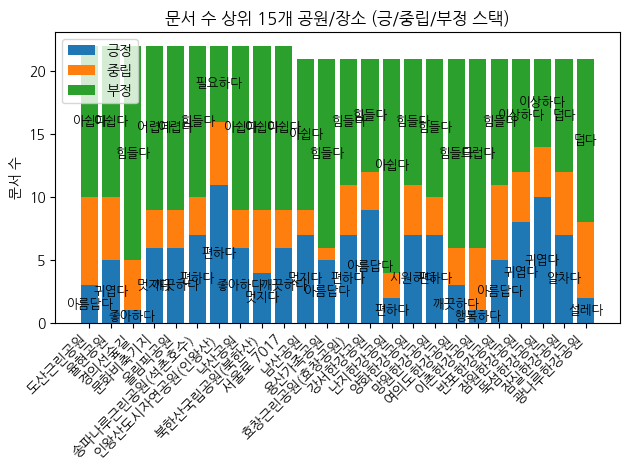

In [12]:
# 2) 문서 수 상위 15 (긍/중립/부정 스택) + Top-1 키워드 라벨
x = np.arange(len(summary_docs_kw))
pos = summary_docs_kw["n_positive"].to_numpy()
neu = summary_docs_kw["n_neutral"].to_numpy()
neg = summary_docs_kw["n_negative"].to_numpy()

plt.figure()
plt.bar(x, pos, label="긍정")
plt.bar(x, neu, bottom=pos, label="중립")
plt.bar(x, neg, bottom=pos+neu, label="부정")
plt.xticks(x, summary_docs_kw["entity"], rotation=45, ha="right")
plt.ylabel("문서 수")
plt.title("문서 수 상위 15개 공원/장소 (긍/중립/부정 스택)")
plt.tight_layout()
plt.legend()

# --- (E) 막대에 키워드 라벨 적기 ---
for i, row in summary_docs_kw.iterrows():
    # 긍정 키워드 라벨: 긍정 막대 중앙
    if row["n_positive"] > 0:
        plt.text(i, row["n_positive"] * 0.5, row["top_pos_kw"], ha="center", va="center", fontsize=9)
    else:
        plt.text(i, 0.3, "—", ha="center", va="bottom", fontsize=9)

    # 부정 키워드 라벨: 최상단(긍정+중립+부정)에서 부정 막대 중앙 위치
    # total_up_to_neg = row["n_positive"] + row["n_neutral"] + row["n_negative"]
    if row["n_negative"] > 0:
        plt.text(i, row["n_positive"] + row["n_neutral"] + row["n_negative"] * 0.5,
                 row["top_neg_kw"], ha="center", va="center", fontsize=9)
    else:
        # 부정이 0이면 최상단 근처에 '—'
        plt.text(i, row["n_positive"] + row["n_neutral"] + 0.3, "—", ha="center", va="bottom", fontsize=9)

plt.show()

In [13]:
# #예쁘다의 비율 알아보기
# import pandas as pd
# import re
# import matplotlib.pyplot as plt
# from matplotlib import font_manager, rcParams
# import os
# from typing import List, Tuple

# # =========================
# # 1) 기존 코드 재사용 (설정 및 감성 분석 함수)
# # =========================

# # === 입력 경로 ===
# IN_PATH = "/content/drive/MyDrive/seoul_datahub_contest/selected_sentences.csv"
# TEXT_COL = "content_clean"

# # === 긍정/부정 단어 및 패턴 생성 로직 (기존 코드와 동일) ===
# USER_POS_WORDS = [
#     "깨끗하다", "조용하다", "알차다", "아름답다", "멋지다", "이쁘다", "편하다", "시원하다", "좋아하다", "설레다",
#     "행복하다", "즐겁다", "귀엽다", "완벽하다", "대단하다", "잔잔하다", "소중하다", "딱이다", "한가롭다", "근사하다"
# ]
# USER_NEG_WORDS = [
#     "아쉽다", "힘들다", "필요하다", "어렵다", "무섭다", "아프다", "비싸다", "밉다",
#     "바쁘다", "아깝다", "불편하다", "덥다", "나쁘다", "좁다", "이상하다", "헷갈리다", "귀찮다", "드럽다"
# ]

# def to_stem_pattern(word: str) -> str:
#     w = word.strip()
#     if w.endswith("다") and len(w) >= 2:
#         stem = w[:-1]
#     else:
#         stem = w
#     return re.escape(stem)

# def build_patterns_from_words(words: List[str]) -> List[str]:
#     patterns = [to_stem_pattern(w) for w in words]
#     return [p for p in dict.fromkeys(patterns) if p]

# POS_PATTERNS = build_patterns_from_words(USER_POS_WORDS)
# NEG_PATTERNS = build_patterns_from_words(USER_NEG_WORDS)

# NEGATION_TOKENS = [r"안", r"못", r"별로", r"전혀", r"않", r"아니"]

# # === 텍스트 정규화 및 감성 분석 함수 (기존 코드와 동일) ===
# def normalize(text: str) -> str:
#     t = str(text).strip().lower() # str() 추가하여 안전성 확보
#     t = re.sub(r"[^\w\s가-힣]", " ", t) # 간단하게 변경
#     t = re.sub(r"\s+", " ", t).strip()
#     return t

# def any_match(patterns: List[str], text: str) -> bool:
#     for p in patterns:
#         if re.search(p, text):
#             return True
#     return False

# def has_negation_nearby(text: str, span: Tuple[int, int], window: int = 4) -> bool:
#     start, end = span
#     left = max(0, start - window)
#     right = min(len(text), end + window)
#     ctx = text[left:right]
#     return any(re.search(nt, ctx) for nt in NEGATION_TOKENS)

# def classify_sentiment_rule(text: str) -> str:
#     t = normalize(text)

#     # 부정어 패턴이 직접적으로 나오면 '부정'
#     if any_match(NEG_PATTERNS, t):
#         return "부정"

#     # 긍정어 패턴 탐색 및 주변 부정 표지 확인
#     for p in POS_PATTERNS:
#         for m in re.finditer(p, t):
#             if has_negation_nearby(t, m.span(), window=4):
#                 return "부정" # 긍정어 주변에 부인어가 있으면 '부정'
#             else:
#                 return "긍정" # 부인어가 없는 긍정어가 하나라도 발견되면 '긍정'

#     return "중립"

# # =========================
# # 2) 데이터 로딩 및 '예쁘다' 비중 분석
# # =========================
# # Google Drive 마운트
# from google.colab import drive
# drive.mount('/content/drive')

# print(f"데이터를 로딩합니다: {IN_PATH}")
# df = pd.read_csv(IN_PATH)

# # 1. 모든 문장에 대해 감성 분석 적용
# df['sentiment'] = df[TEXT_COL].fillna("").apply(classify_sentiment_rule)

# # 2. 긍정으로 분류된 문장만 필터링
# positive_df = df[df['sentiment'] == '긍정'].copy()
# total_positive_count = len(positive_df)
# print(f"\n총 문장 수: {len(df)}개")
# print(f"긍정으로 분류된 문장 수: {total_positive_count}개")

# # 3. '예쁘다'의 어간 패턴 생성 ('이쁘다'도 동일하게 처리하기 위해 리스트로 관리)
# # '예쁘다'와 '이쁘다'는 의미가 같으므로 함께 카운트
# pretty_patterns = [
#     to_stem_pattern("예쁘다"), # '예쁘'
#     to_stem_pattern("이쁘다")  # '이쁘'
# ]

# # 4. 긍정 문장 중에서 '예쁘다' 또는 '이쁘다'가 포함된 문장 카운트
# # 정규화된 텍스트에서 패턴이 하나라도 발견되면 True
# positive_df['contains_pretty'] = positive_df[TEXT_COL].fillna("").apply(
#     lambda text: any_match(pretty_patterns, normalize(text))
# )
# pretty_count = positive_df['contains_pretty'].sum()

# # 5. '예쁘다'가 없는 긍정 문장 카운트
# other_positive_count = total_positive_count - pretty_count

# print(f"✅ '예쁘다'/'이쁘다' 포함 긍정 문장: {pretty_count}개")
# print(f"✅ 나머지 긍정 문장: {other_positive_count}개")


# # =========================
# # 3) 파이 그래프로 시각화
# # =========================
# # Colab의 기본 한글 폰트(나눔고딕) 설정
# font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
# if os.path.exists(font_path):
#     font_manager.fontManager.addfont(font_path)
#     rcParams["font.family"] = "NanumGothic"
#     rcParams["axes.unicode_minus"] = False
#     print("\n✅ 한글 폰트가 설정되었습니다.")
# else:
#     print("\n⚠️ 나눔고딕 폰트를 찾을 수 없어 시각화에 한글이 깨질 수 있습니다.")

# # 그래프 데이터 준비
# labels = [f"'예쁘다'/'이쁘다' 포함 ({pretty_count}개)", f"기타 긍정 표현 ({other_positive_count}개)"]
# sizes = [pretty_count, other_positive_count]
# colors = ['#ff9999', '#66b3ff']
# explode = (0.1, 0)  # 첫 번째 조각('예쁘다')을 약간 떼어내어 강조

# # 파이 그래프 그리기
# plt.figure(figsize=(10, 8))
# plt.pie(sizes, explode=explode, labels=labels, colors=colors,
#         autopct='%1.1f%%', # 소수점 첫째 자리까지 퍼센트 표시
#         shadow=True, startangle=140, textprops={'fontsize': 14})

# plt.title("전체 긍정 문장에서 '예쁘다'의 비중", fontsize=20, pad=20)
# plt.axis('equal')  # 파이를 원형으로 유지
# plt.show()

# 시각화 후보 1

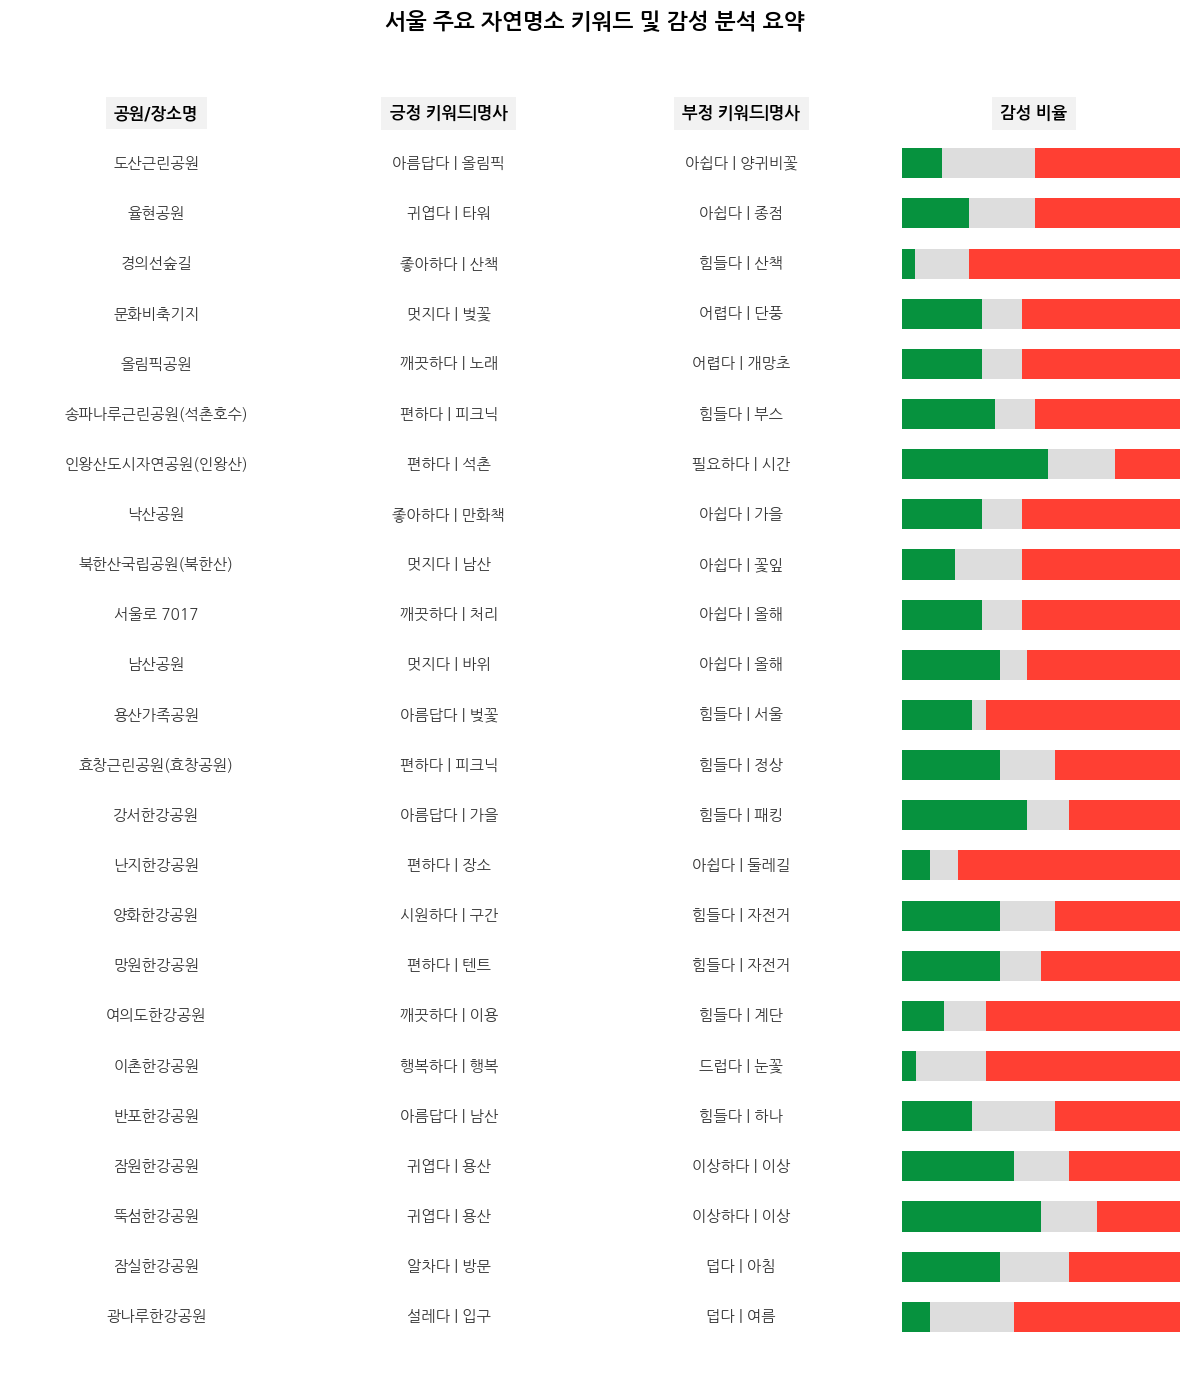

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 이전에 생성된 summary_docs_kw 데이터프레임이 있다고 가정합니다 ---
# summary_docs_kw = pd.read_csv(...) # 만약 새로 시작한다면 로드

# 폰트 설정 (기존 코드와 동일)
import os
from matplotlib import font_manager, rcParams
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
if os.path.exists(font_path):
    font_manager.fontManager.addfont(font_path)
    rcParams["font.family"] = "NanumGothic"
    rcParams["axes.unicode_minus"] = False

df_plot = summary_docs_kw.sort_values("n_docs", ascending=False)

# --- 테이블 시각화 시작 ---

# Figure와 Axes 생성
# fig, ax = plt.subplots(figsize=(12, 8))
n_rows = len(df_plot)
# 행 하나당 0.5인치, 제목과 여백을 위한 2인치를 더해줌
fig_height = n_rows * 0.5 + 2
fig, ax = plt.subplots(figsize=(12, fig_height))

# 테이블의 행과 열 개수
n_rows, n_cols = len(df_plot), 4
ax.set_ylim(-1, n_rows) # 행 위치 조절
ax.set_xlim(0, n_cols)

# 테이블 배경 및 테두리 숨기기
ax.axis('off')

# 색상 정의
POS_COLOR = "#06923E"
NEU_COLOR = "#dddddd" # 중립 색을 연한 회색으로 변경하여 가독성 확보
NEG_COLOR = "#FF3F33"
HEADER_COLOR = '#f2f2f2'
FONT_COLOR = '#333333'

# 테이블 헤더 생성
headers = ['공원/장소명', '긍정 키워드|명사', '부정 키워드|명사', '감성 비율']
for j, header in enumerate(headers):
    ax.text(j + 0.5, n_rows, header, ha='center', va='center', fontsize=12, weight='bold',
            bbox=dict(boxstyle='square,pad=0.5', fc=HEADER_COLOR, ec='none'))

# 테이블 내용 채우기 (한 행씩)
for i in range(n_rows):
    row_data = df_plot.iloc[i]

    # 1. 텍스트 정보 (공원명, 긍정/부정 키워드) 추가
    ax.text(0.5, n_rows - 1 - i, row_data['entity'], ha='center', va='center', fontsize=11, color=FONT_COLOR)
    ax.text(1.5, n_rows - 1 - i, row_data['pos_label'], ha='center', va='center', fontsize=11, color=FONT_COLOR)
    ax.text(2.5, n_rows - 1 - i, row_data['neg_label'], ha='center', va='center', fontsize=11, color=FONT_COLOR)

    # 2. 감성 비율 막대 그래프 추가
    total = row_data['n_docs']
    if total > 0:
        pos_ratio = row_data['n_positive'] / total
        neu_ratio = row_data['n_neutral'] / total
        neg_ratio = row_data['n_negative'] / total

        # 막대 위치 (x_start) 계산 및 그리기
        x_start = 3.05 # 4번째 열의 시작 위치
        ax.barh(n_rows - 1 - i, pos_ratio, height=0.6, left=x_start, color=POS_COLOR)
        ax.barh(n_rows - 1 - i, neu_ratio, height=0.6, left=x_start + pos_ratio, color=NEU_COLOR)
        ax.barh(n_rows - 1 - i, neg_ratio, height=0.6, left=x_start + pos_ratio + neu_ratio, color=NEG_COLOR)

# 차트 제목 추가
fig.suptitle('서울 주요 자연명소 키워드 및 감성 분석 요약', fontsize=16, weight='bold', y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95]) # 제목과 겹치지 않도록 레이아웃 조절

plt.show()